# Logistic Regression Model: Training and Evaluation
This notebook walks through training a logistic regression model for classifying normal vs cataract cases using extracted features from images.

In [1]:
# Importing Libraries
from pathlib import Path
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE  # For handling imbalanced datasets

## Paths and Configuration
Define paths for the datasets and model files.

In [2]:
# Paths to datasets and model
from src.config import MODELS_DIR, PROCESSED_DATA_DIR

feature_cataract_path_csv = PROCESSED_DATA_DIR / "feature_matrix_cataract.csv"
feature_normal_path_csv = PROCESSED_DATA_DIR / "feature_matrix_normal.csv"
model_path = MODELS_DIR / "model.pkl"

2025-01-07 01:24:04.812 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: /home/sih/Documents/GI/l4_s1/ml/cataract-ai


## Step 1: Load the Datasets
We load the features for normal and cataract cases and label them appropriately.

In [3]:
# Load the datasets
normal_df = pd.read_csv(feature_normal_path_csv)
cataract_df = pd.read_csv(feature_cataract_path_csv)

# Add labels: 0 for normal, 1 for cataract
normal_df["label"] = 0
cataract_df["label"] = 1

# Merge datasets
df = pd.concat([normal_df, cataract_df], ignore_index=True)
print("Datasets loaded successfully.")

Datasets loaded successfully.


## Step 2: Exploratory Data Analysis (EDA)
Visualize feature distributions, outliers, correlations, and class distribution.

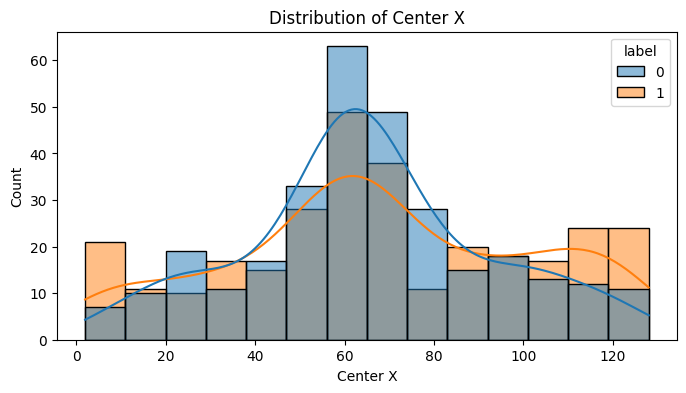

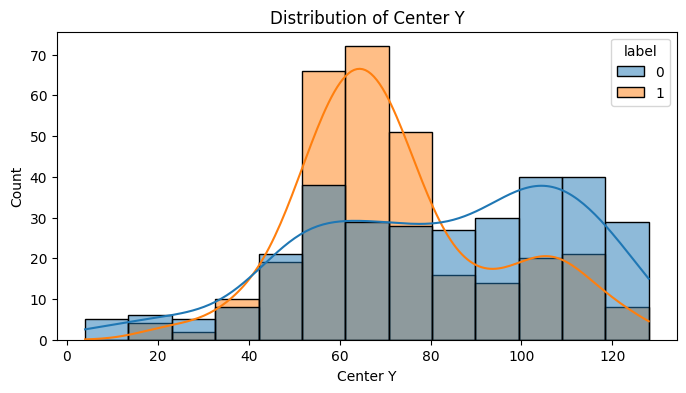

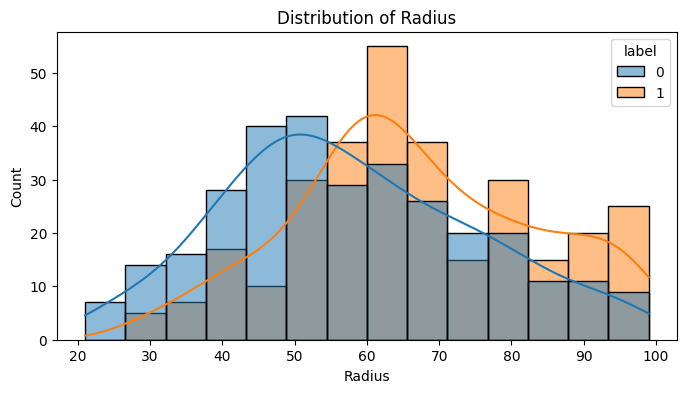

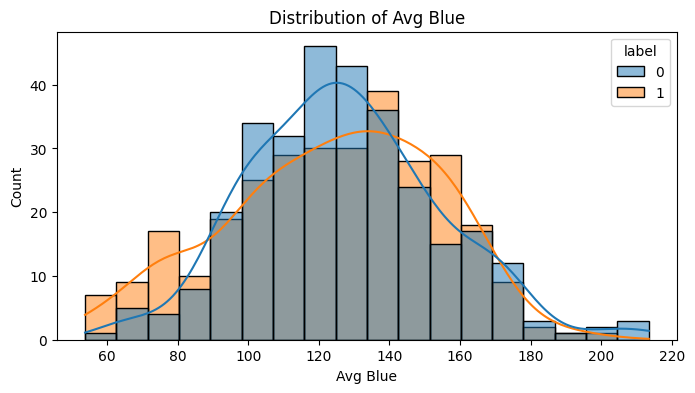

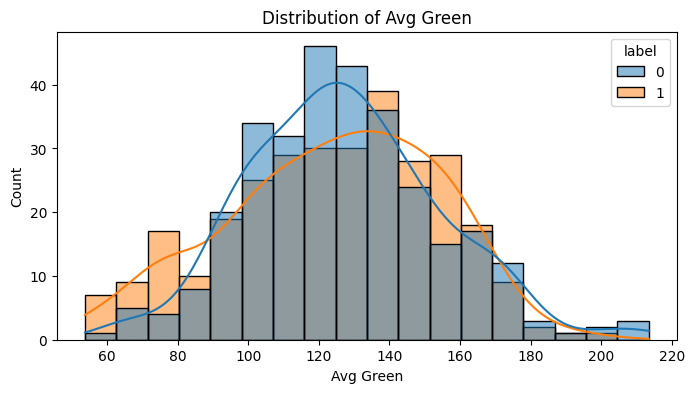

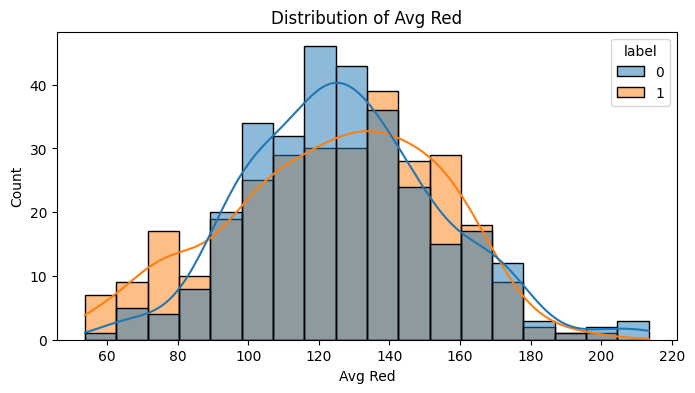

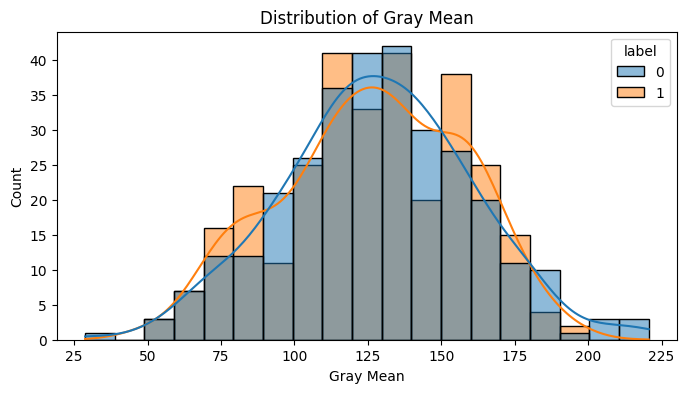

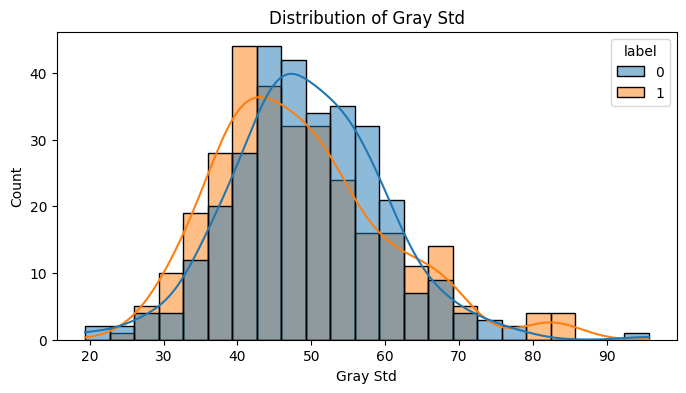

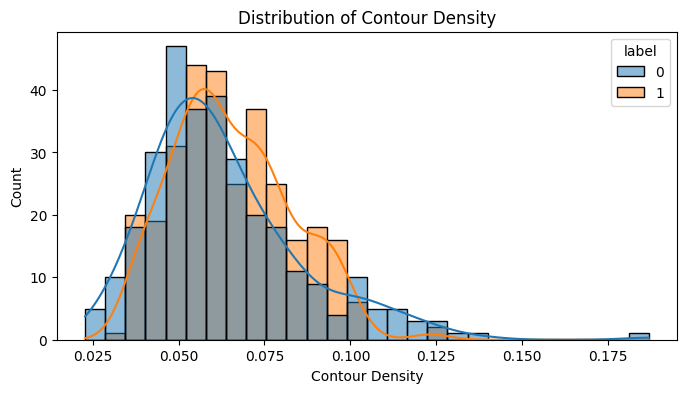

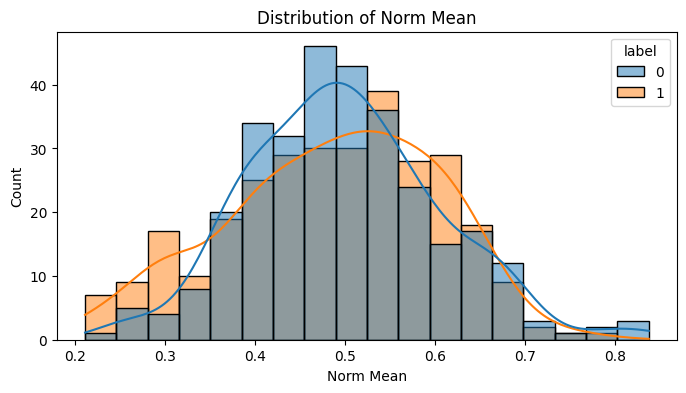

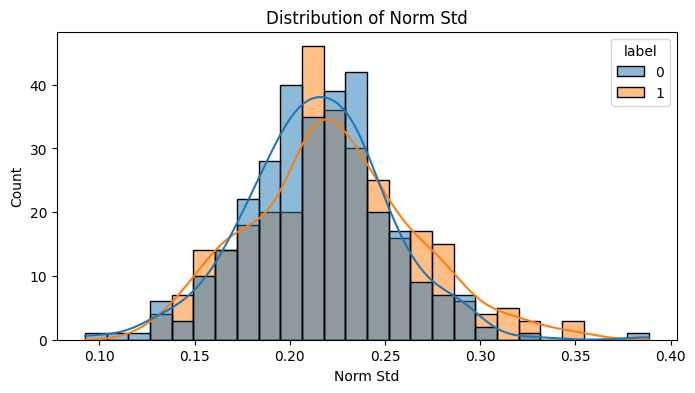

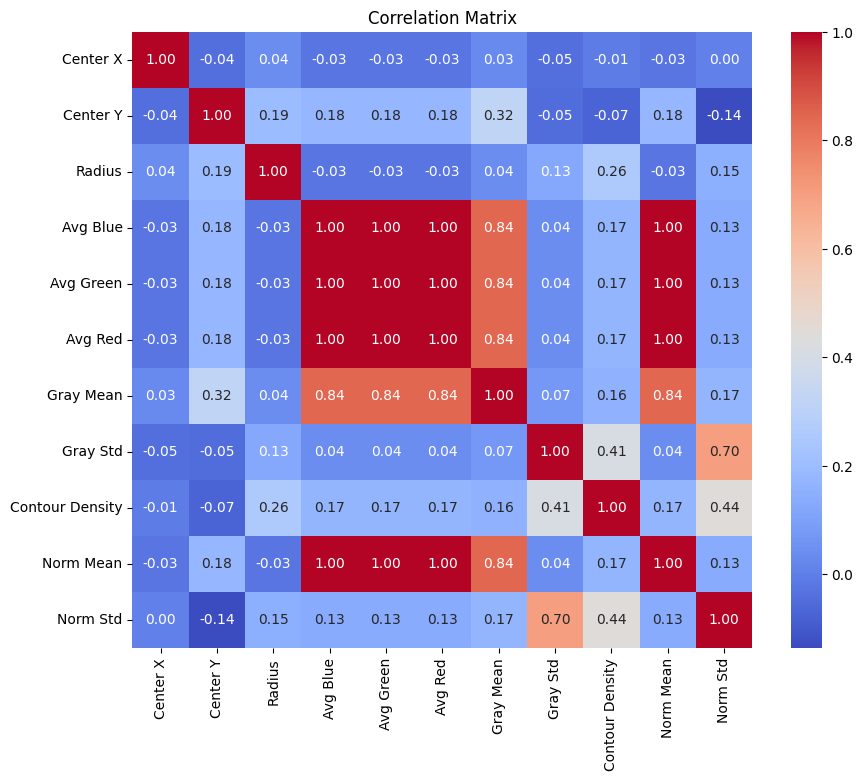

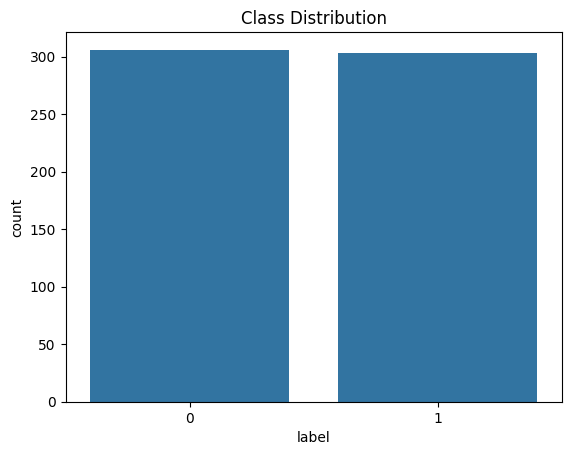

In [4]:
# Perform EDA
features = df.columns[:-1]  # Exclude the 'label' column

# Feature distributions
for feature in features:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df, x=feature, hue="label", kde=True)
    plt.title(f"Distribution of {feature}")
    plt.show()

# Correlation matrix
correlation_matrix = df[features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Class distribution
sns.countplot(data=df, x="label")
plt.title("Class Distribution")
plt.show()

## Step 3: Data Preparation
Handle class imbalance using SMOTE and standardize the features.

In [5]:
# Split features and labels
X, y = df.iloc[:, :-1], df["label"]

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)
print("Data preparation completed.")

Data preparation completed.


## Step 4: Train-Test Split
Split the data into training, validation, and test sets.

In [6]:
# Train-test split
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)
print("Data split into training, validation, and test sets.")

Data split into training, validation, and test sets.


## Step 5: Model Training
Train the logistic regression model using the training data.

In [7]:
# Train logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Save the trained model
with open(model_path, "wb") as file:
    pickle.dump(model, file)
print("Model trained and saved successfully.")

Model trained and saved successfully.


## Step 6: Model Evaluation
Evaluate the model using validation and test datasets.

Validation Results:
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        46
           1       0.70      0.70      0.70        46

    accuracy                           0.70        92
   macro avg       0.70      0.70      0.70        92
weighted avg       0.70      0.70      0.70        92

Test Results:
              precision    recall  f1-score   support

           0       0.51      0.54      0.53        46
           1       0.51      0.48      0.49        46

    accuracy                           0.51        92
   macro avg       0.51      0.51      0.51        92
weighted avg       0.51      0.51      0.51        92



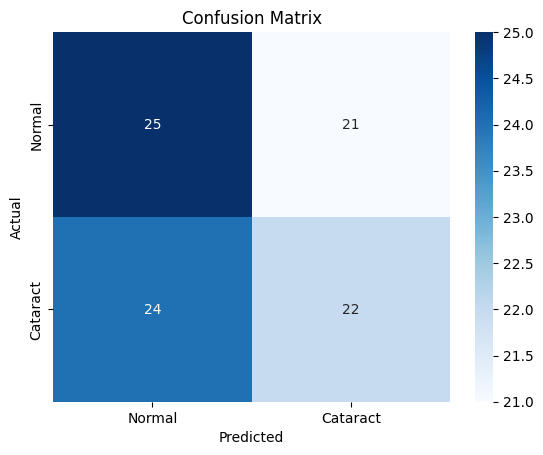

Text(0.5, 1.0, 'ROC Curve')

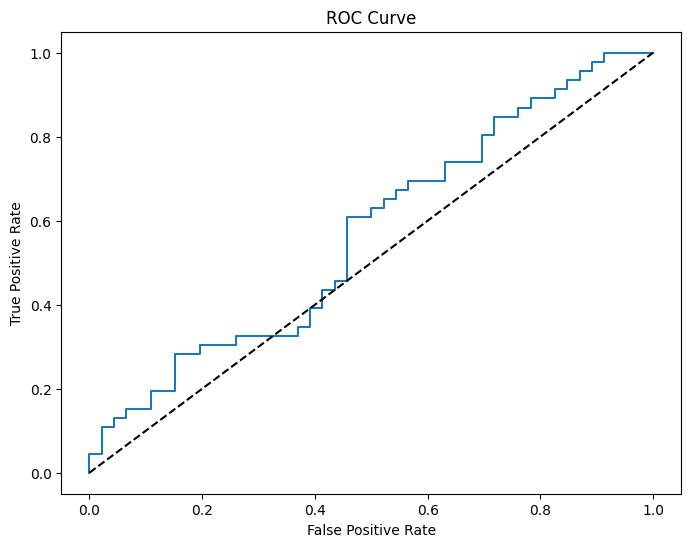

In [8]:
# Validate the model
y_val_pred = model.predict(X_val)
print("Validation Results:")
print(classification_report(y_val, y_val_pred))

# Evaluate on test set
y_test_pred = model.predict(X_test)
print("Test Results:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Cataract"], yticklabels=["Normal", "Cataract"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
y_test_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")